In [1]:
import pandas as pd
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')
val_df = pd.read_csv('dataset/val.csv')

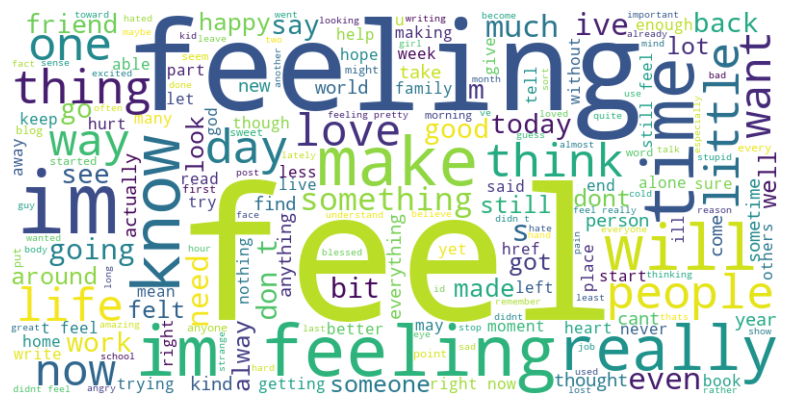

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 合併所有文本
text = ' '.join(train_df['text'])

# 創建WordCloud對象
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)

# 顯示生成的文字地圖
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


使用BERT分詞器（BertTokenizer），這個分詞器在將文本轉換為模型能理解的格式時已自動處理了一些基本的文本清理步驟。
包含轉換為小寫、去除在分詞過程中不會保留的特殊字符

input_ids: 這是將文本轉換成數字ID的結果。每個ID都對應於BERT分詞器的一個特定詞或子詞單元。這些ID的序列是用於訓練模型的輸入數據。
token_type_ids: 這個序列通常用於區分多個句子的類型，例如在問答任務中。在單句情緒分析任務中，這個序列可能不是必需的。
attention_mask: 這個序列用於指示模型哪些位置是實際的數據，哪些位置是填充的。這對於模型正確處理不等長的輸入數據至關重要。

### 建立Stopwords

In [5]:
import string
import nltk
from nltk.corpus import stopwords

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Update the cleaning function to remove stopwords
def clean_text_with_stopwords(text):
    # Convert to lower case and remove specific expressions
    text = text.lower().replace("i ", "").replace("im ", "").replace("i am ", "").replace("am ", "")
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the updated cleaning function to the text data
train_df['text'] = train_df['text'].apply(clean_text_with_stopwords)
val_df['text'] = val_df['text'].apply(clean_text_with_stopwords)
test_df['text'] = test_df['text'].apply(clean_text_with_stopwords)

# Show the cleaned text from each dataset
train_df.head(), val_df.head(), test_df.head()

(                                                text  emotion
 0                              didnt feel humiliated  sadness
 1  go feeling hopeless damned hopeful around some...  sadness
 2             grabbing minute post feel greedy wrong    anger
 3  ever feeling nostalgic fireplace know still pr...     love
 4                                    feeling grouchy    anger,
                                                 text  emotion
 0              feeling quite sad sorry ill snap soon  sadness
 1  feel like still looking blank canvas blank pie...  sadness
 2                         feel like faithful servant     love
 3                                feeling cranky blue    anger
 4                              treat feeling festive      joy,
                                                 text  emotion
 0              feeling rather rotten ambitious right  sadness
 1                          updating blog feel shitty  sadness
 2    never make separate ever want feel like ashamed

LSTM模型的數據準備：

分詞：將所有句子分解成單詞。
建立詞彙表：從訓練集中創建一個詞彙表，將每個唯一單詞映射到一個整數索引。
文本向量化：將每個句子轉換成整數序列，這些整數代表對應單詞的索引。
序列填充：因為LSTM模型需要固定長度的輸入，我們將使用填充來確保所有輸入序列都有相同的長度。
首先，我們需要建立詞彙表並對所有文本數據進行分詞。讓我們從計算詞彙表大小並進行文本向量化開始。

1. 使用 Tokenizer 從Keras來對文本進行分詞並建立詞彙表。
2. 將文本轉換為數字序列。
3. 使用序列填充，使所有文本數據具有相同的長度，這是神經網絡模型處理批數據的要求。

In [9]:
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer with a specific number of words
tokenizer = Tokenizer(num_words=10000)  # Limiting to top 10,000 words
tokenizer.fit_on_texts(train_df['text'])

# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
val_sequences = tokenizer.texts_to_sequences(val_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

# Padding sequences to ensure uniform input size
max_length = max(max(len(seq) for seq in train_sequences), 
                 max(len(seq) for seq in val_sequences), 
                 max(len(seq) for seq in test_sequences))
train_padded = pad_sequences(train_sequences, maxlen=max_length)
val_padded = pad_sequences(val_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

max_length, train_padded.shape, val_padded.shape, test_padded.shape


(34, (16000, 34), (2000, 34), (2000, 34))

In [47]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.utils import to_categorical

# Step 2: Preparing the labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['emotion'])
val_labels = label_encoder.transform(val_df['emotion'])
test_labels = label_encoder.transform(test_df['emotion'])

# Convert labels to categorical
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

# Step 3: Building the LSTM Model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=max_length))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# 添加早停法
from tf_keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer='adam', # 使用Adam優化器，它是一種基於梯度下降的方法，能自動調整學習率，適用於大多數深度學習任務
              loss='categorical_crossentropy', 
              metrics=['accuracy']) # 設置評估指標為準確率，即模型預測正確的比例

# Step 4: Training the model
history = model.fit(train_padded, train_labels, epochs=15, batch_size=64, validation_data=(val_padded, val_labels))

# Step 5: Evaluating the model
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2833 - loss: 1.6973 - val_accuracy: 0.3805 - val_loss: 1.3985
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5169 - loss: 1.1996 - val_accuracy: 0.7635 - val_loss: 0.7308
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7647 - loss: 0.6468 - val_accuracy: 0.8355 - val_loss: 0.5046
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8386 - loss: 0.4413 - val_accuracy: 0.8590 - val_loss: 0.4250
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8799 - loss: 0.3492 - val_accuracy: 0.8675 - val_loss: 0.4107
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9010 - loss: 0.2874 - val_accuracy: 0.8760 - val_loss: 0.3737
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9132 - loss: 0.2504 - val_accuracy: 0.8765 - val_loss: 0.3710
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9268 - loss: 0.2108 - val_accu

In [48]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (64, 34, 34)           │       340,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (64, 34, 34)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (64, 32)               │         8,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (64, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (64, 16)               │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (64, 6)                │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,047,620 (4.00 MB)

 Trainable params: 349,206 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 698,414 (2.66 MB)

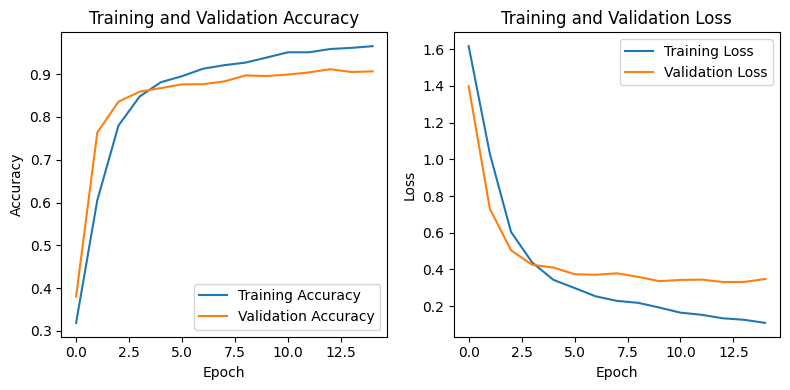

In [49]:
import matplotlib.pyplot as plt
# 绘制训练和验证的准确度
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 绘制训练和验证的损失
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
